Main goal of this notebook is to use the google earth engine to identify and create features that represent the shoreline/waterline of the wetland projects based on different parameters like NDWI, VV and VH backscatter, and individual mutispectral bands

In [ ]:
## before anything you need to visit the site below and make sure you have a google earth engine account
## this is so you can access Sentinel-1 GRD and Sentinel-2 TOA and SR products, as well as other sensor packages and data types

## visit the below website below to setup an earth engine account, enable a cloud project, and enable the ee API 
## https://developers.google.com/earth-engine/cloud/earthengine_cloud_project_setup#get-access-to-earth-engine

In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
## only need to run this once
## after authenticating with google earth engine you will only need to initialize each session

## https://developers.google.com/earth-engine/guides/auth
ee.Authenticate()

In [2]:
## init ee cloud project you made during initial setup
ee.Initialize(project = '') ##enter your project name here as a string to initialize exchanges with ee api

# Some functions for a bit easier mapping
super simple for now, might make them better later

In [3]:
## Function to add RGB images to the map.
def add_rgb_to_map(image, map_object, coll):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    for band in coll.first().bandNames().getInfo(): ## all images if small enough image collection
        map_object.addLayer(image, {'min': 0, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}, f'{date}_rgb')

## Function to add spectral indices images to the map.
def add_ind_to_map(image, map_object, coll):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    for band in coll.first().bandNames().getInfo():
        if band =='NDWI':
            map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': ['00FFFF', '0000FF']}, f'{date}_{band}')
        elif band =='NDVI': 
            map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': ['FF0000', '008000']}, f'{date}_{band}')

## Function to add spectral indices images to the map.
def add_sar_to_map(image, map_object, coll, target_band):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    for band in coll.first().bandNames().getInfo():
        if band == target_band:
            map_object.addLayer(image, {'min': -50, 'max': 1, 'bands': band}, f'{date}_{band}')

In [4]:
## functiont to create three important and popular spectral indices
## ndvi = Normalized Difference Vegetation Index, good for vegetation health and cover
## ndwi = Normalized Difference Water Index, good for identifying water bodies and mositure in surface
def s2_10m_target_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands([ndvi, ndwi])

## collects sentinel-1 GRD (radar, no phase) and Sentinel-2 SR (multispectral, adjusted for top of atmosphere reflectance)
def get_sentinel_imagery(aoi, start_date, end_date, s2_cloud_cov, orbit):
    ## Sentinel-1 ImageCollection
    s1_VV = (ee.ImageCollection('COPERNICUS/S1_GRD')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.eq('orbitProperties_pass', orbit))
               .select(['VV'])
               .sort('date')
    )

    s1_VH = (ee.ImageCollection('COPERNICUS/S1_GRD')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.eq('orbitProperties_pass', orbit))
               .select(['VH'])
               .sort('date')
    )

    ## Clip all images in the collection to the AOI
    s1_VV = s1_VV.map(lambda img: img.clip(aoi))
    s1_VH = s1_VH.map(lambda img:img.clip(aoi))
    ## Sentinel-2 Surface Reflectance Harmonized ImageCollection
    s2_10m = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', s2_cloud_cov))
               .sort('date')
               .select(['B2', 'B3', 'B4', 'B8'])
    )
    ## Clip all images in the collection to the AOI
    s2_10m = s2_10m.map(lambda img: img.clip(aoi))
    ## Apply indices to the Sentinel-2 images
    s2_10m_ndvi = s2_10m.map(s2_10m_target_indices).select(['NDVI'])
    s2_10m_ndwi = s2_10m.map(s2_10m_target_indices).select(['NDWI'])
    
    return s1_VV, s1_VH, s2_10m, s2_10m_ndvi, s2_10m_ndwi


In [5]:
## fucntion to get the date of each image in the image collection
def get_date(image):
    return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd')})

In [6]:
def export_image_to_drive(collection, collname, image, index):
    # Define the description for the export, incorporating the index for uniqueness

    if collname == 's1_VV':
        description = f"s1_VV_{index}"
    elif collname == 's1_VH':
        description = f's1_VH_{index}'
    elif collname == 'rgb':
        description = f's2_10m_{index}'
    elif collname == 'ndvi':
        description = f's2_10m_ndvi_{index}'
    else:
        description = f's2_10m_ndwi_{index}'

    # Setup the export task
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        region=aoi,  # Make sure the geometry is defined earlier
        fileFormat='GeoTIFF',
        scale = 10
    )
    task.start()
    print(f'Exporting {description} to Drive...')

def export_all_images(collection, collname):
    image_list = collection.toList(collection.size())  # Convert ImageCollection to List
    num_images = image_list.size().getInfo()  # Get the number of images

    if collname[:2] == 's1':
        for i, date in enumerate(s1_date_list):
            image = ee.Image(image_list.get(i))
            export_image_to_drive(collection, collname, image, date[:10])

    else:
        for i, date in enumerate(s2_date_list):
            image = ee.Image(image_list.get(i))
            export_image_to_drive(collection, collname, image, date[:10])

In [7]:
## fucntion to get the date of each image in the image collection
def get_date(image):
    return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd')})

In [40]:
# Define a function to get histogram of NDWI for each image
def get_histogram(image, scale, bucket_num, band_name):
    """
    Used to create ndwi histograms for the imagery

    image = ee.Image
        NDWI image to determine the shoreline from
    scale = int
        scale to estimate the histogram from, typically 10 to match the resolution of the RGB imagery
    bucket_num = int
        number of buckets to put the data into for histogram
    band_name = str
        the name of your target band in the image
    """


    # Reduce the image to get a histogram over the region of interest (ROI)
    hist = image.reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=bucket_num),  # Adjust the number of buckets as needed
        geometry=aoi,
        scale=scale,  # Adjust based on image resolution
        maxPixels=1e8
    )
    
    # Get the histogram data for NDWI
    histogram = ee.Dictionary(hist.get(band_name)).getInfo() 
    
    return histogram

# Get area of interest

In [10]:
## interactive map for you to draw a polygon to signify your aoi

## Create a map centered at a specific location
m = geemap.Map(center=[20, 0], zoom=2, basemap='HYBRID')
## Add drawing tools
m.add_draw_control()
## Display the map
display(m)

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [11]:
## Get the drawn features
draw_features = m.draw_features[0]
## Establish ee.Polygon from drawn area of interest to collect imagery
aoi = ee.Geometry.Polygon(draw_features.getInfo()['geometry']['coordinates'][0])

# Get Imagery

In [12]:
start_date = '2019-09-01' ## start date of search window
end_date = '2024-09-01' ## end date of search window
s2_cloud_cov = 10 ## percentage of clouds in sentinel-2 multispectral imagery, less means you see more surface
orbit = 'ASCENDING' ## orbit for imagery

collections = {}
for i in range(int(start_date[:4]), int(end_date[:4])):
    collections[f's1_VV_{i}_{i+1}'], collections[f's1_VH_{i}_{i+1}'], collections[f's2_10m_{i}_{i+1}'], collections[f's2_10m_ndvi_{i}_{i+1}'], collections[f's2_10m_ndwi_{i}_{i+1}'] = get_sentinel_imagery(aoi, f'{i}{start_date[4:]}', f'{i+1}{end_date[4:]}', s2_cloud_cov, orbit)

In [13]:
colls = []
for i, coll in enumerate(collections):
    if collections[coll].size().getInfo() != 0: # removes image collections that are empty
        colls.append(coll)

for i, coll in enumerate(colls):
    print(f'{i}: {coll}')

0: s1_VV_2019_2020
1: s1_VH_2019_2020
2: s2_10m_2019_2020
3: s2_10m_ndvi_2019_2020
4: s2_10m_ndwi_2019_2020
5: s1_VV_2020_2021
6: s1_VH_2020_2021
7: s2_10m_2020_2021
8: s2_10m_ndvi_2020_2021
9: s2_10m_ndwi_2020_2021
10: s1_VV_2021_2022
11: s1_VH_2021_2022
12: s2_10m_2021_2022
13: s2_10m_ndvi_2021_2022
14: s2_10m_ndwi_2021_2022
15: s1_VV_2022_2023
16: s1_VH_2022_2023
17: s2_10m_2022_2023
18: s2_10m_ndvi_2022_2023
19: s2_10m_ndwi_2022_2023
20: s1_VV_2023_2024
21: s1_VH_2023_2024
22: s2_10m_2023_2024
23: s2_10m_ndvi_2023_2024
24: s2_10m_ndwi_2023_2024


In [344]:
collections[colls[22]]

Name,Description
B1,Aerosols
B2,Blue
B3,Green
B4,Red
B5,Red Edge 1
B6,Red Edge 2
B7,Red Edge 3
B8,NIR
B8A,Red Edge 4
B9,Water vapor


# Visualize Distribution of Values for Select Images

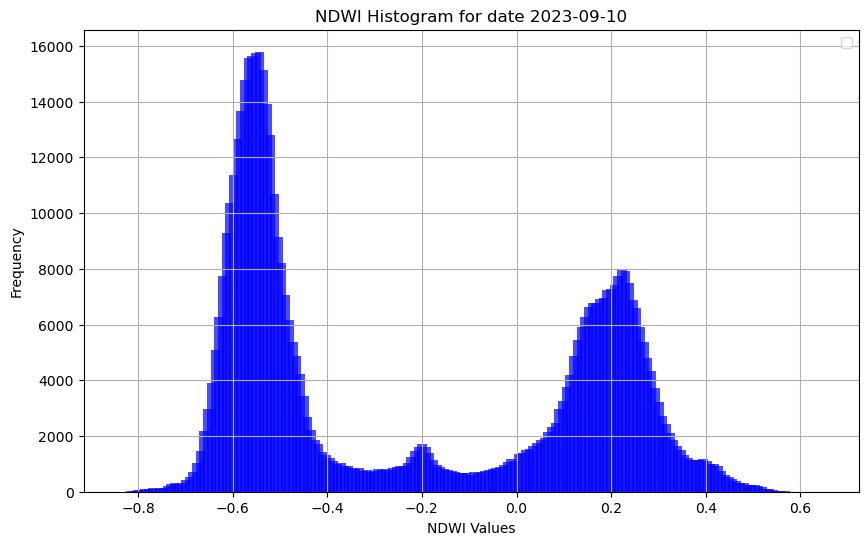

In [402]:
# all I need for segmenting images into coastlines would be
# Need to make this applicable for each image in image collection
# it will read in a specified band of a passed image collection, then segment it using Otsu's method
# It should create a new image collection of 
#   1) Water Bodies, 2) Land Bodies, 3) Shorelines
# those can then be used to measure horizontal changes in shoreline over time

# Get the first image in the collection (or map over the collection if needed)
s2_date_list = collections[colls[24]].map(get_date).aggregate_array('date').getInfo()


ndwi_image = collections[colls[24]].first()
ndwi_date = s2_date_list[0]
ndwi_histogram = get_histogram(ndwi_image, 10, 150, 'NDWI')

# Extract the histogram values for plotting
ndwi_values = ndwi_histogram['bucketMeans']
ndwi_counts = ndwi_histogram['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(ndwi_values, ndwi_counts, width=0.02, color='blue', alpha=0.7)
plt.title(f"NDWI Histogram for date {ndwi_date}")
plt.xlabel("NDWI Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


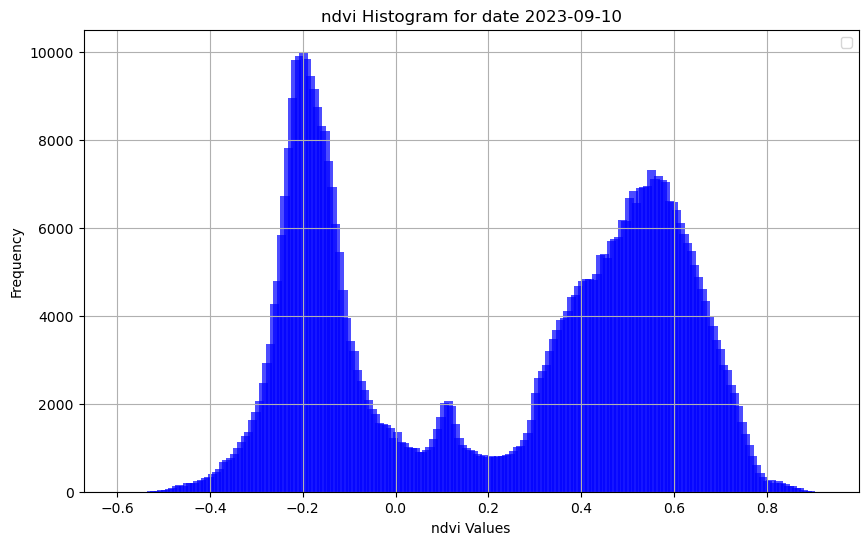

In [278]:

# using this to test if I can use ndvi and NDVI to improve shoreline edge detection
ndvi_image = collections[colls[23]].first()
ndvi_date = s2_date_list[0]
ndvi_histogram = get_histogram(ndvi_image, 10, 150, 'NDVI')

# Extract the histogram values for plotting
ndvi_values = ndvi_histogram['bucketMeans']
ndvi_counts = ndvi_histogram['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(ndvi_values, ndvi_counts, width=0.02, color='blue', alpha=0.7)
plt.title(f"ndvi Histogram for date {ndvi_date}")
plt.xlabel("ndvi Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


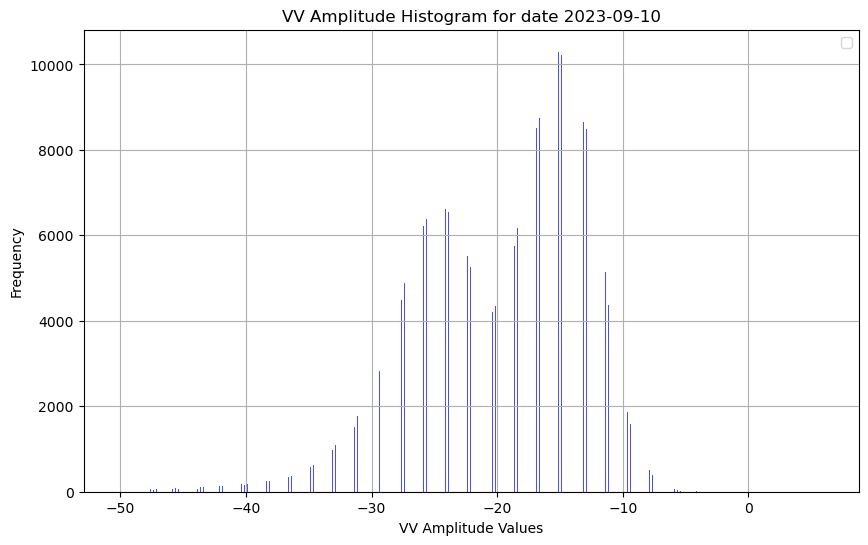

In [403]:
# Trying with VV and VH to see if there are differences in shoreline identification
# will also compare with individual bands as well

s1_date_list = collections[colls[20]].map(get_date).aggregate_array('date').getInfo()
sar_date = s2_date_list[0]
vh_image = collections[colls[21]].first()
vv_image = collections[colls[20]].first()

# Extract the histogram values for plotting
vv_values = vv_histogram['bucketMeans']
vv_counts = vv_histogram['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(vv_values, vv_counts, width=0.02, color='blue', alpha=0.7)
plt.title(f"VV Amplitude Histogram for date {sar_date}")
plt.xlabel("VV Amplitude Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

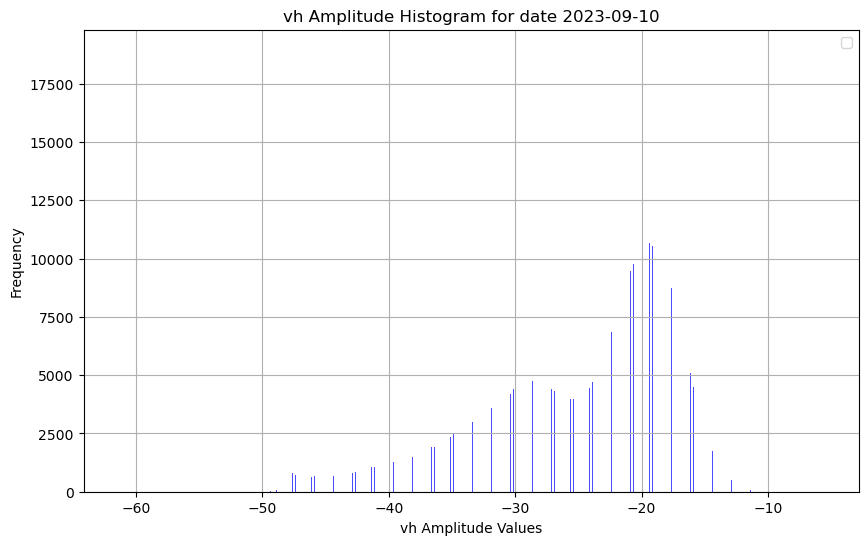

In [404]:
vv_histogram = get_histogram(vv_image, 10, 150, 'VV')
vh_histogram = get_histogram(vh_image, 10, 150, 'VH')

# Extract the histogram values for plotting
vh_values = vh_histogram['bucketMeans']
vh_counts = vh_histogram['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(vh_values, vh_counts, width=0.02, color='blue', alpha=0.7)
plt.title(f"vh Amplitude Histogram for date {sar_date}")
plt.xlabel("vh Amplitude Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

- Does not look like VH Backscatter Ampltidue from Sentinel-1 C-band can be used for determining the shorelines in marshlands 

# Trying Canny Edge Detection for shoreline detection as well

In [405]:
#### find a method to iterate thorugh each image
#### do images in the image collections individually to compare changes
#### once each shoreline image is created individually, then export individually

ndwi_edges = ee.Algorithms.CannyEdgeDetector(ndwi_image, threshold=.25, sigma=1)
ndwi_edges_mask = ndwi_edges.gt(0)
ndwi_edges = ndwi_edges.rename('Canny_Edges') 


ndwi_lines = ndwi_edges_mask.selfMask().reduceToVectors(
geometryType='polygon',  # Extract edges as lines
reducer=ee.Reducer.countEvery(),  # Count every edge pixel
scale=10,  # Adjust scale based on the resolution of the image
geometry=aoi,  # Constrain to the area of interest
maxPixels=1e8
)

In [ ]:
Export.image.toDrive({
    'image': first_edge_image,
    'description': 'Canny_Edges_Example',
    'scale': 10,  # Adjust the scale according to the dataset resolution
    'region': aoi,
    'maxPixels': 1e8
})

# Map RGB Imagery

In [406]:
rgb_image = collections[colls[22]].first()

# Display the shoreline as vector features
Map = geemap.Map()

# Add the original NDWI image for context
Map.addLayer(rgb_image, {'min': 0, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}, f'Sentinel-2 RGB {ndwi_date}')
Map.addLayer(vv_image, {'min': -50, 'max': 1}, f'Sentinel-1 GRD VV {sar_date}')
Map.addLayer(vh_image, {'min': -50, 'max': 1}, f'Sentinel-1 GRD VH {sar_date}')

# Visualize the edges (the result of Canny Edge Detection)
Map.addLayer(ndwi_lines, {'color': 'White'}, 'Smoothed Canny Lines (NDWI)')

# Display the map
Map.addLayerControl()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# Export Shoreline information

In [ ]:
# Export the shoreline vector as GeoJSON for use in QGIS or GDAL
task = ee.batch.Export.table.toDrive(
    collection=vector_shoreline,
    description='Shoreline_Export',
    fileFormat='GeoJSON',  # GeoJSON is well-supported in QGIS and GDAL
    fileNamePrefix='shoreline'
)

# Start the export task
task.start()
print("Shoreline extraction task started, check Google Earth Engine tasks for progress.")